In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc

Part 1: Implementing and plotting the Mandelbrot set

In [4]:
# hyperparameters
# bounds for the search space [x,y]
lowerBounds = [-2.0, -1.5]
upperBounds = [1.0, 1.5]

In [ ]:
def mandelbrot(c, max_iter):
    '''
    Determines whether complex number c lies within the mandelbrot set via the escape time algorithm.
    
    Args:
        c (complex):    Complex number to be tested.
        max_iter (int): Number of iterations to perform.
        
    Returns:
        z (complex): The complex number at iteration max_iter.
        n (int): The number of iterations before the escape condition is reached.
    '''
    z = 0 + 0j
    n = 0
    while abs(z) <= 2 and n < max_iter:
        z = z*z + c
        n += 1
        
    return z, n

def plot_mandelbrot(width, height, max_iter):
    '''
    Plots the Mandelbrot set at a given resolution and number of iterations.
    
    Args:
        width (int):    width of generated image in pixels.
        height (int):   height of generated image in pixels.
        max_iter (int): maximum number of iterations to be performed when calculating the set.
    
    Returns:
        None
    '''
    
    # Set arrays to store the mandelbrot set
    x, y = np.linspace(lowerBounds[0], upperBounds[0], width), np.linspace(lowerBounds[1], upperBounds[1], height)
    mandelbrot_set = np.empty((height, width))
    mandelbrot_set_bool = np.empty((height, width))
    
    # Calculate the mandelbrot set
    for i in range(height):
        for j in range(width):
            z, mandelbrot_set[i, j] = mandelbrot(x[j] + 1j * y[i], max_iter)
            if abs(z) <= 2:
                mandelbrot_set_bool[i, j] = 1
            else:
                mandelbrot_set_bool[i, j] = 0
    
    plt.figure(figsize=(10, 10))
    plt.imshow(mandelbrot_set, extent=(lowerBounds[0], upperBounds[0], lowerBounds[1], upperBounds[1]),
               cmap='inferno', interpolation='bilinear')
    plt.colorbar()
    plt.title("Mandelbrot Set")
    plt.xlabel("Re")
    plt.ylabel("Im")
    plt.show()
    
    print(mandelbrot_set_bool)
    plt.figure(figsize=(10, 10))
    plt.imshow(mandelbrot_set_bool)
    plt.colorbar()
    plt.title("Mandelbrot Set")
    plt.xlabel("Re")
    plt.ylabel("Im")
    plt.show()

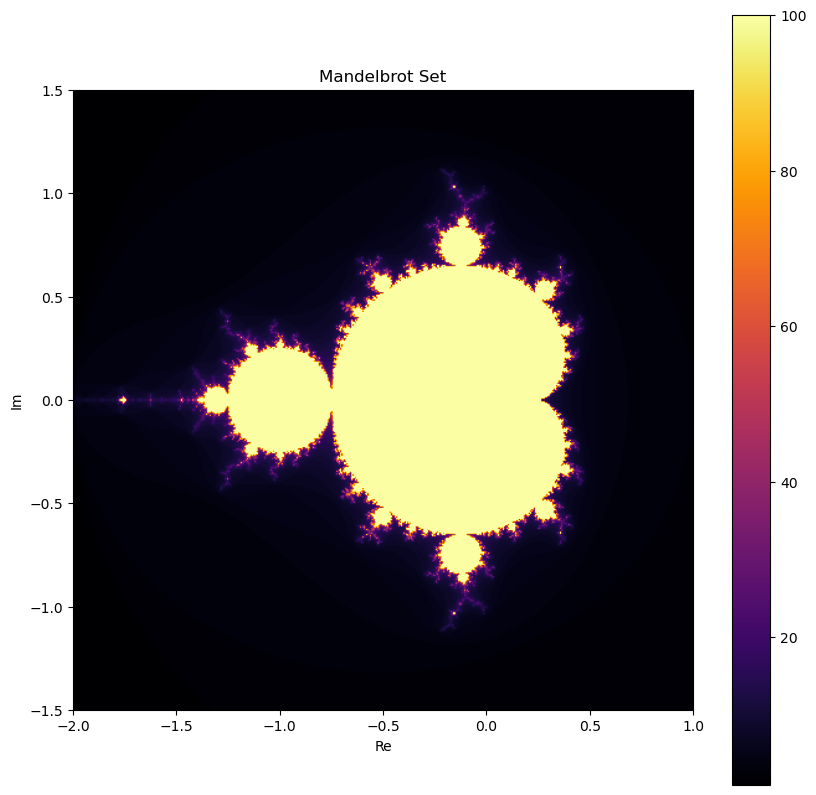

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


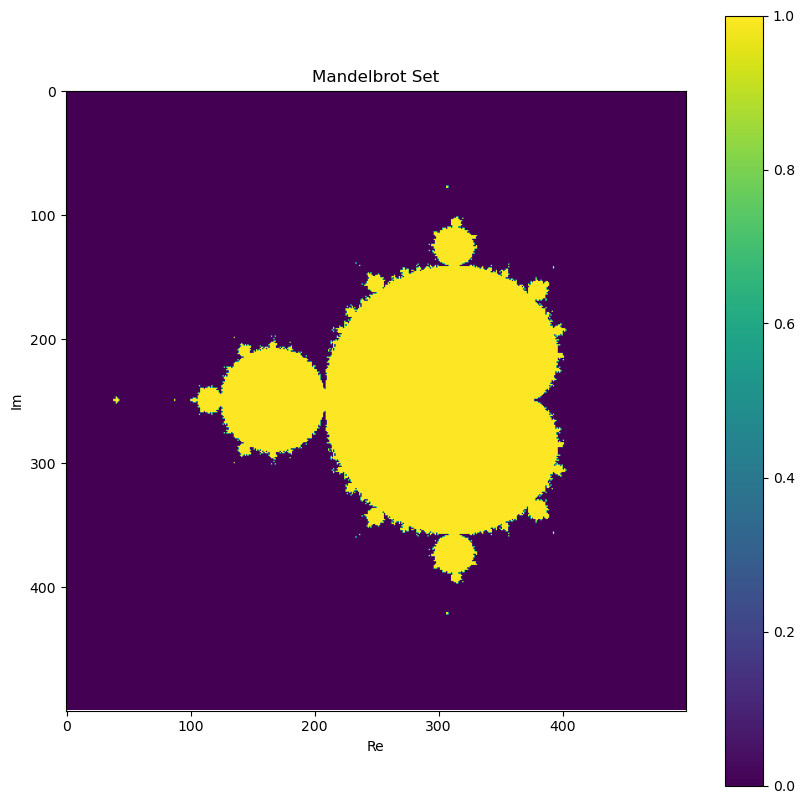

In [6]:
# Plot the Mandelbrot set with given parameters
plot_mandelbrot(500, 500, 100)

Part 2

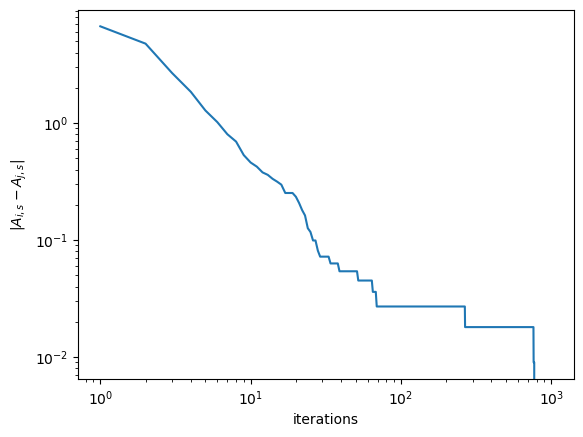

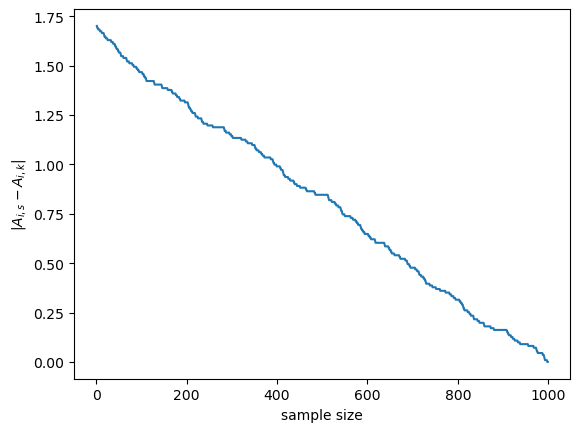

In [ ]:
def get_random_sample(sample_size,sampling_method="random"):
    # use latin hypercube sampling to sample points in the square
    if sampling_method == "latin":

        sampler = qmc.LatinHypercube(d=2,strength=1)
        sample = sampler.random(sample_size)
        sample_scaled = qmc.scale(sample, lowerBounds, upperBounds)

    # number of points needs to be p**2 where p is a prime number
    if sampling_method == "orthogonal":

        sampler = qmc.LatinHypercube(d=2,strength=2)
        sample = sampler.random(sample_size)
        sample_scaled = qmc.scale(sample, lowerBounds, upperBounds)
    
    # use pure random sampling
    if sampling_method == "random":
        sample_scaled = np.random.uniform(low=lowerBounds, high=upperBounds, size=(sample_size, 2))
    
    return sample_scaled


sample_size = 1000
sample_scaled = get_random_sample(sample_size)
max_iter = 1000

# check MC for one value of max_iter, do for multiple sample sizes
area_of_region = abs(upperBounds[0] - lowerBounds[0]) * abs(upperBounds[1] - lowerBounds[1]) 
areas = []
for iter in range(max_iter):
    mc_count = 0
    
    for i in range(sample_size):
            z, _ = mandelbrot(sample_scaled[i][0] + 1j * sample_scaled[i][1], iter)
        
            if abs(z) <= 2:
                mc_count += 1
            
    current_area = (float(mc_count) * area_of_region) / sample_size
    areas.append(current_area)

areas = np.array(areas)

plt.figure()
plt.ylabel(r"|$A_{i,s} - A_{j,s}$|")
plt.xlabel("iterations")
plt.plot(np.arange(1,max_iter,1),abs(areas-areas[-1])[1::])
plt.yscale("log")
plt.xscale("log")


sample_size = 1000
sample_scaled = get_random_sample(sample_size)
max_iter = 1000

# Not sure abt this part still, probably we don't need this (estimate error on s theoretically)
area_of_region = abs(upperBounds[0] - lowerBounds[0]) * abs(upperBounds[1] - lowerBounds[1]) 
areas = []
for s in range(sample_size):
    mc_count = 0
    
    for i in range(s):
            z, _ = mandelbrot(sample_scaled[i][0] + 1j * sample_scaled[i][1], iter)
        
            if abs(z) <= 2:
                mc_count += 1
            
    current_area = (float(mc_count) * area_of_region) / sample_size
    areas.append(current_area)

areas = np.array(areas)

plt.figure()
plt.ylabel(r"|$A_{i,s} - A_{i,k}$|")
plt.xlabel("sample size")
plt.plot(np.arange(1,sample_size,1),abs(areas-areas[-1])[1::])
#plt.yscale("log")
#plt.xscale("log")



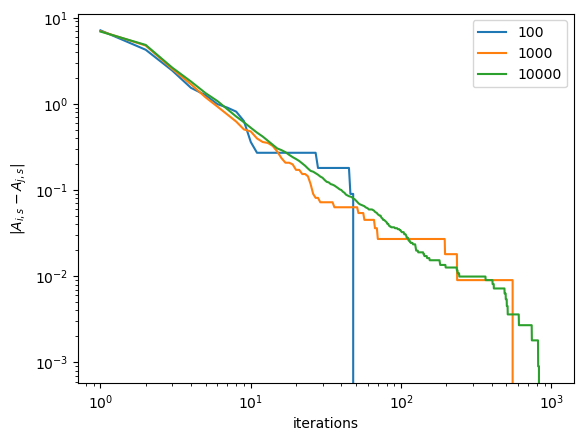

In [32]:
area_of_region = abs(upperBounds[0] - lowerBounds[0]) * abs(upperBounds[1] - lowerBounds[1]) 
max_iter = 1000
sample_sizes = [100,1000,10000]

plt.figure()
# we can do this for multiple runs to get a confidence
# check MC for one value of max_iter, do for multiple sample sizes
for sample_size in sample_sizes:
    # get a random sample
    sample_scaled = get_random_sample(sample_size)
    areas = []

    # find area and convergence to area for given maximal iterations and sample size
    for iter in range(max_iter):
        mc_count = 0
        
        for i in range(sample_size):
                z, _ = mandelbrot(sample_scaled[i][0] + 1j * sample_scaled[i][1], iter)
            
                if abs(z) <= 2:
                    mc_count += 1
                
        current_area = (float(mc_count) * area_of_region) / sample_size
        areas.append(current_area)

    areas = np.array(areas)

    plt.plot(np.arange(1,max_iter,1),abs(areas-areas[-1])[1::],label=f"{sample_size}")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.ylabel(r"|$A_{i,s} - A_{j,s}$|")
plt.xlabel("iterations")
plt.show()



